# Reinforcement Fine Tuning (RFT) with GRPO
* This notebook was open sourced/forked from Daily Dose of Data Science by Avi Chawla. Sign up [here](https://www.dailydoseofds.com/), his newsletters are amazing tidbits to keep updated on AI/ML/DS!
* Date: 4/4/2025

# Overview
* Reinforcement Fine-tuning (RFT) allows you to transform any open-source LLM into a reasoning powerhouse.
* The great thing about RFT? No labeled data is required!
* This notebook uses Predibase for RFT to transform `Qwen-2.5-7b` into a reasoning model.
* RFT uses an online “reward” approach with no static labels required!!
  * The RFT model is able to explore various outputs, and a Reward Function will score their correctness.
  * Over time, the model learns to generate higher-reward answers using GRPO.

## Supervised Fine Tuning (SFT) vs. RFT
  * SFT will use static data and often memorizes answers.
  * RFT, being an online method, is able to learn from rewards and explore new strategies.
* The diagram below is also from the same blog:

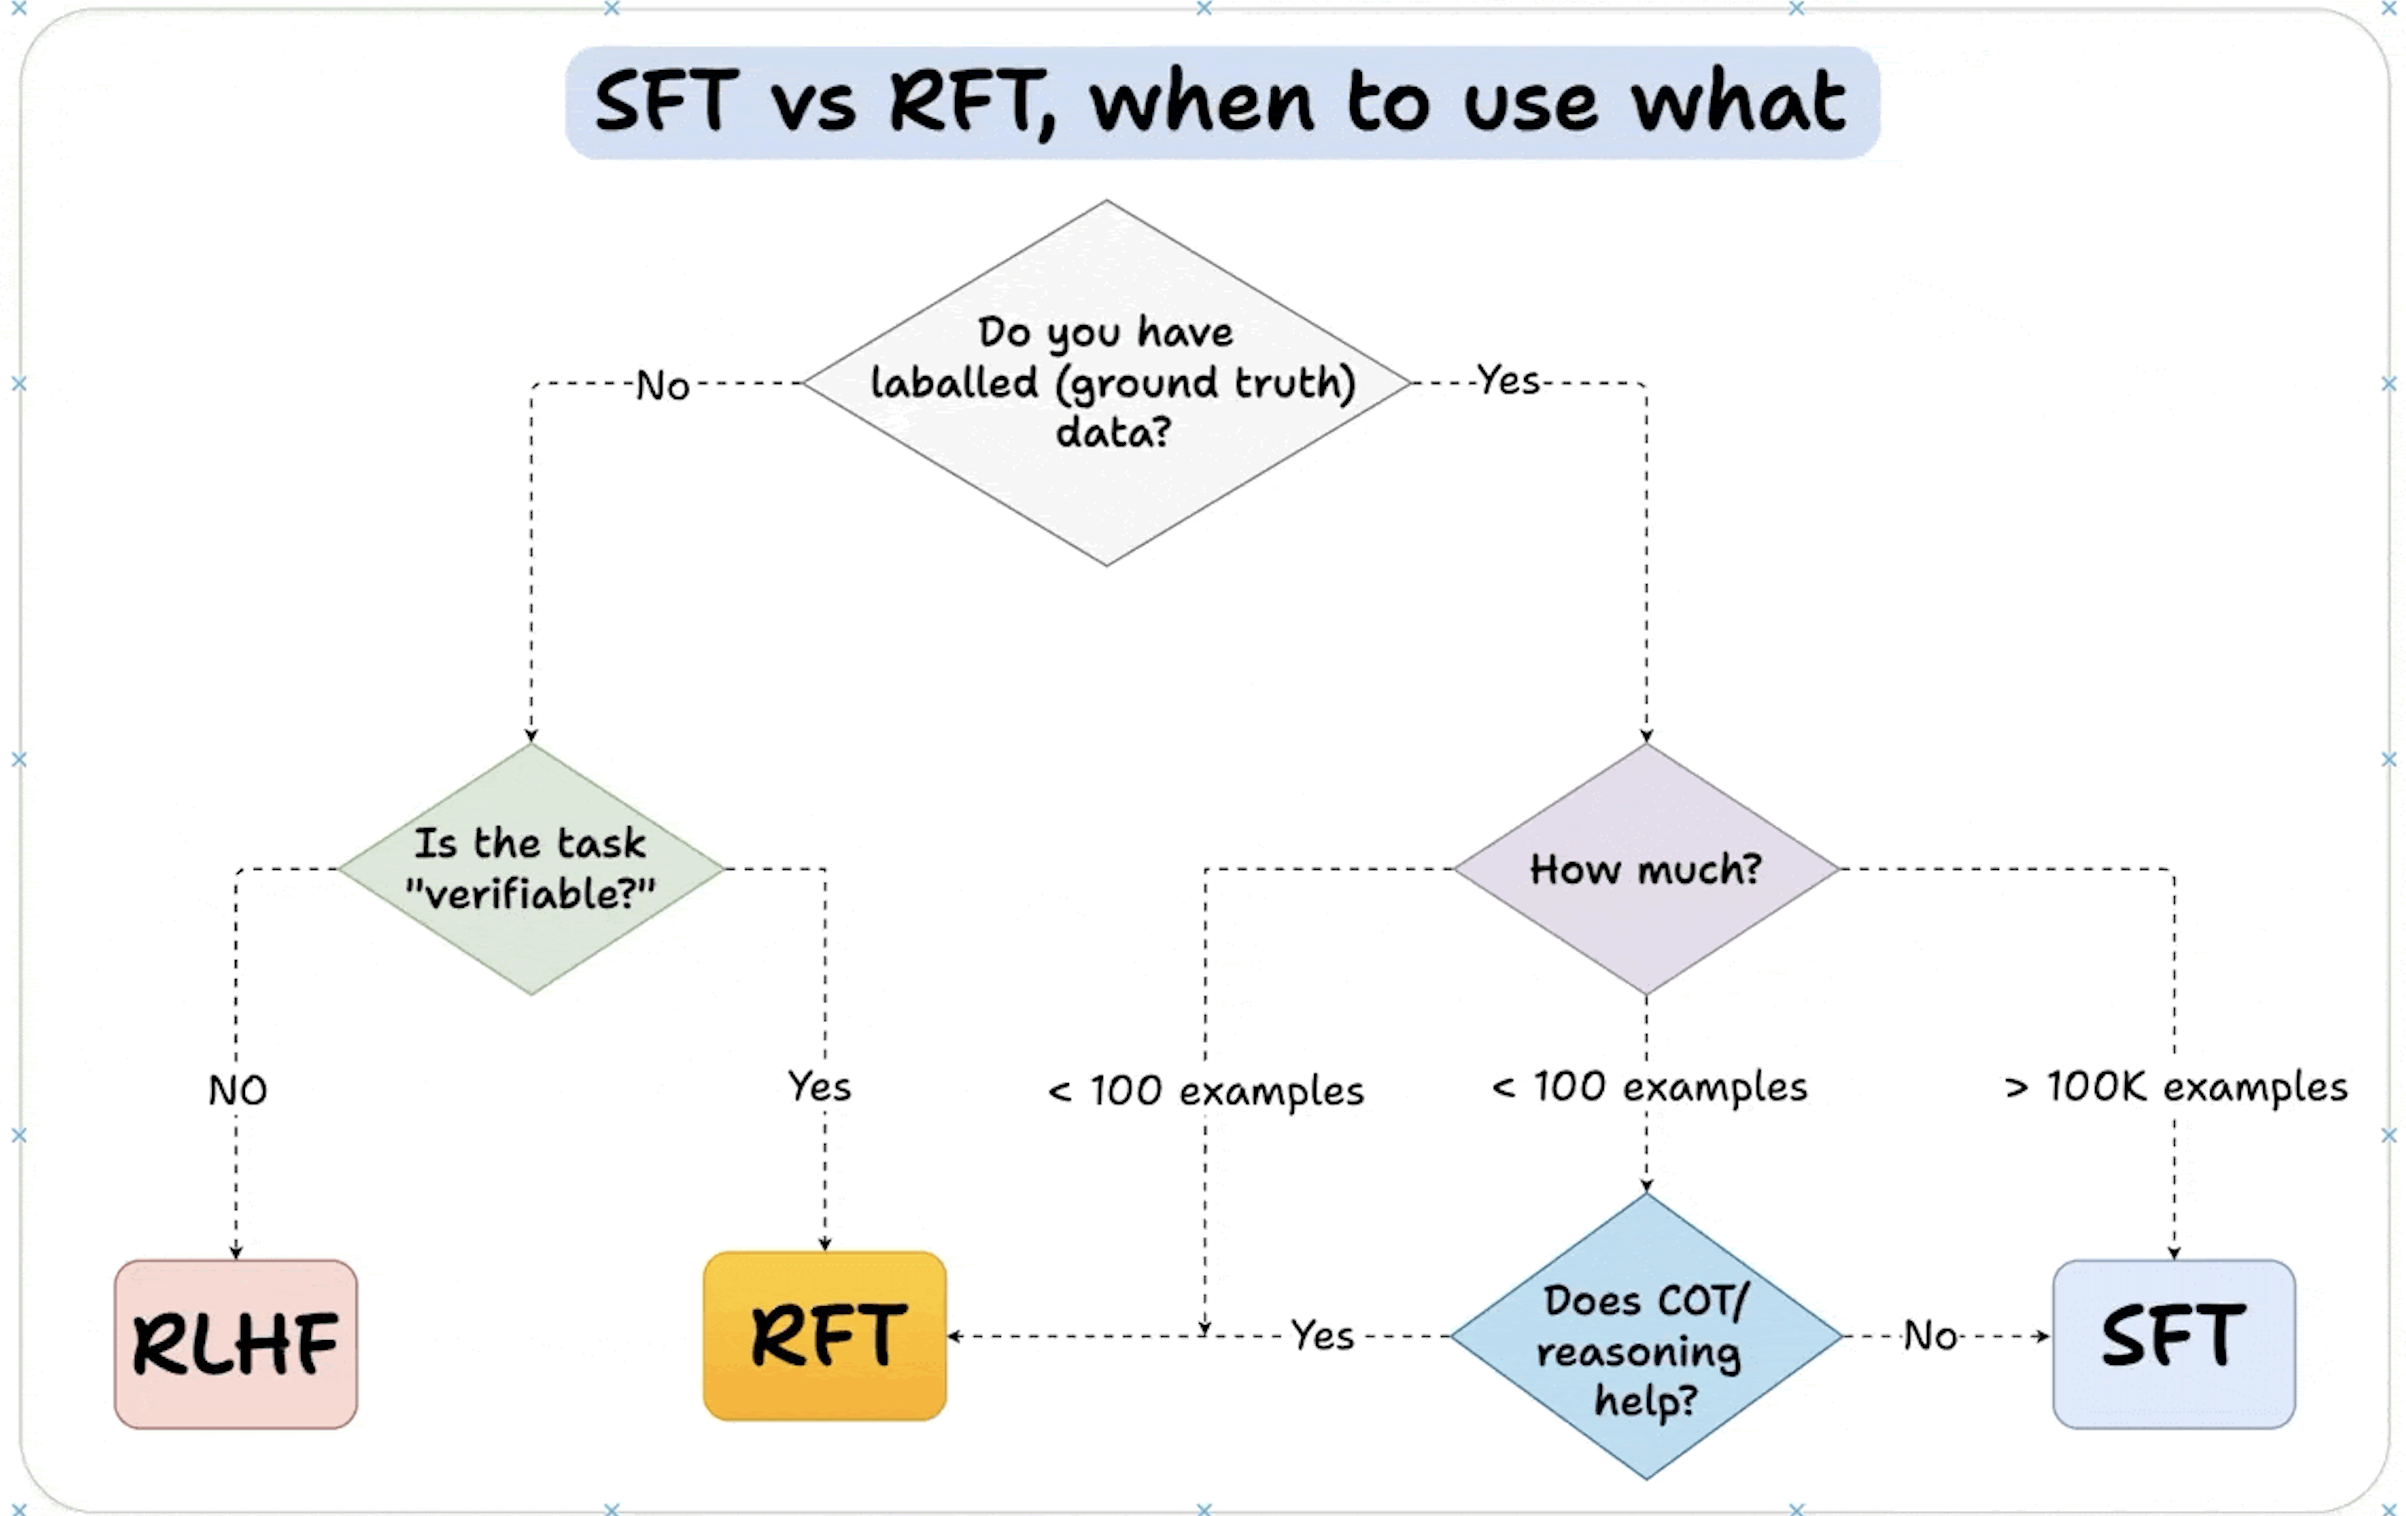


# What is GRPO again?
* GRPO, or Group Relative Policy Optimization, is a reinforcement learning algorithm designed to enhance large language model (LLM) reasoning by evaluating groups of responses relative to each other, rather than relying on external critics.

* These are some important points about GRPO:

1. **Purpose of GRPO**
  * GRPO aims to improve the reasoning capabilities of LLMs, especially for tasks requiring complex problem-solving and long chains of thought.

2. **Method of GRPO**
  * The goal of GRPO is to optimize the model by evaluating groups of responses generated for the same prompt, comparing their performance relative to each other.

3. **Reinforcement Learning**
  * GRPO is a reinforcement learning algorithm, meaning it learns through trial and error, using rewards to guide the model's behavior.

4. **Group-Based Advantage Estimation (GRAE)**
  * GRPO uses GRAE to estimate the advantage of each response within a group by comparing its reward to the average reward of the group.

5. **Training Workflow**
  * Generate a group of multiple responses from the LLM for a given prompt.
  * Score the group (reward model).
  * Calculate group relative advantages (GRAE - comparing within the group).
  * Optimize policy (PPO-like objective with GRAE).

6. **Efficiency of GRPO**
  * GRPO is designed to be more efficient than traditional reinforcement learning methods, as it eliminates the need for a separate value function (critic).

# Where did GRPO come from?
* GRPO was introduced by DeepSeek AI. GRPO was used in the post-training of DeepSeek-R1 which is the model that has

# Why GRPO?
* [source](https://medium.com/@sahin.samia/the-math-behind-deepseek-a-deep-dive-into-group-relative-policy-optimization-grpo-8a75007491ba)
* As mentioned above, traditional RL methods like Proximal Policy Optimization (PPO) face significant challenges when applied to reasoning tasks in LLMs:

1. **Dependency on a Critic Model**
  * Proximal Policy Optimization (PPO) requires a separate critic model to estimate the value of each response, which doubles memory and computational requirements.
  * Training a critic model is complex and often prone to errors, especially for tasks with subjective or nuanced evaluations.

2. **Very High Computational Cost and Memory Use**
  * RL pipelines often demand significant computational resources to evaluate and optimize responses iteratively.
  * Scaling these methods to large LLMs exacerbates these costs.

3. **Scalability Issues**
  * Absolute reward evaluations struggle with diverse tasks, making it hard to generalize across reasoning domains.

### ⚠️ **Warning: Please note that running the GRPO training job in this notebook to completion has an estimated cost of over $300**.

GRPO training runs for 1000 steps by default. You can stop your training job early via the UI after you're satisfied with seeing the performance. (For example after 50-100 steps is where you can start to see the model learning the rewards.)

# Predibase Environment Set Up
* Predibase allows you to use Reinforcement Fine-Tuning (RFT) out of the box on their platform.
* RFT is inspired by the success of DeepSeek-RL and DPO, RFT lets teams rapidly guide model behavior with minimal data, no retraining, and up to 20% higher accuracy than GPT-4 on domain-specific tasks.
* Read more about [Predibase here](https://medium.com/@devinthedetail.blog/the-first-end-to-end-platform-for-reinforcement-fine-tuning-534ffa95e584)

First of all get your API keys here (you get $25 Free credits): https://predibase.com/fine-tuning

In [ ]:
! pip install predibase
! pip install datasets

In [ ]:
!python --version

Python 3.11.11


In [ ]:
from predibase import *

pb = Predibase(api_token = "{replace_with_token}")

# Data Preprocessing & Training Objective
* In this demo we fine-tune the model using the Countdown dataset, a popular resource for evaluating and enhancing the reasoning and math capabilities of an LLM.
* This is passed as a prompt template in the code.

In [ ]:
template = """<|im_start|>system
You are a helpful assistant. You first think about the reasoning process step by step and then provide the user with an answer.<|im_end|>
<|im_start|>user
Using the numbers {nums}, create an equation that equals {target}. You can use basic arithmetic operations (+, -, *, /) and parentheses, and each number can only be used once. Show your work in <think> </think> tags. And return the final equation and answer in <answer> </answer> tags, for example <answer> (1 + 2) / 3 </answer>.<|im_end|>
<|im_start|>assistant
Let me solve this step by step.
<think>"""

In [ ]:
def format_row(row):
    return template.format(
        nums=row["nums"],
        target=row["target"]
    )

# Load Dataset

In [ ]:
import pandas as pd
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("predibase/countdown")
train_df = pd.DataFrame(dataset["train"])
eval_df = pd.DataFrame(dataset["test"])

In [ ]:
train_df["prompt"] = train_df.apply(format_row, axis=1)
eval_df["prompt"] = eval_df.apply(format_row, axis=1)

print("train_df")
print(train_df.head(5))
print(eval_df.iloc[0]["prompt"])
print("--------")
print("eval_df")
print(eval_df.head(5))
print(eval_df.iloc[0]["prompt"])

train_df.to_json("./countdown_train.jsonl", lines=True, orient="records")

# Reward Functions
Reward functions are how the model will determine how well it's doing during training. It's important to understand how they are defined.

## 1. Format Reward Function
* The `format_reward_func` below checks whether the models output contains a `<think>` block and an `<answer>` block in the correct order.
* If it does, the model scores +1. Otherwise, it is zero.

In [ ]:
import regex as re
from typing import List, Dict, Any

## 1. Format reward function
# Check if the output is properly formatted
def format_reward_func(prompt: str, completion: str, example: dict[str, str]) -> int:
    # Imported packages must be inside each reward function
    import re

    reward = 0
    try:
        # Add synthetic <think> as it's already part of the prompt and prefilled
        # for the assistant to more easily match the regex
        completion = "<think>" + completion

        # Check if the format matches expected pattern:
        # <think> content </think> followed by <answer> content </answer>
        regex = (
            r"^<think>\s*([^<]*(?:<(?!/?think>)[^<]*)*)\s*<\/think>\n"
            r"<answer>\s*([\s\S]*?)\s*<\/answer>$"
        )

        # Search for the regex in the completion
        match = re.search(regex, completion, re.DOTALL)
        if match is not None and len(match.groups()) == 2:
            reward = 1.0
    except Exception:
        pass

    print(f"Format reward: {reward}")
    return reward



## 2. Equation Reward Function
* Next, we parse the models final equation.
* Then check the following:
  * 1. if it uses all numbers once
  2. contains only valid math symbols, and...
  3. correctly calculates the target

* If everything is correct, the reward is +1.

In [ ]:
# Check if the output contains the correct answer
def equation_reward_func(prompt: str, completion: str, example: dict[str, str]) -> int:
    # Imported packages must be inside each reward function
    import re
    import ast

    reward = 0.0
    try:
        # add synthetic <think> as its already part of the prompt and prefilled
        # for the assistant to more easily match the regex
        completion = "<think>" + completion
        match = re.search(r"<answer>\s*([\s\S]*?)\s*<\/answer>", completion)
        if not match:
            print("No answer found in completion. Equation reward: 0.0")
            return 0.0

        # Extract the "answer" part from the completion
        equation = match.group(1).strip()
        # Extract all numbers from the equation
        used_numbers = [int(n) for n in re.findall(r'\d+', equation)]

        # Convert the example["nums"] to a list if it's a string
        # This is common for columns like lists in datasets
        if isinstance(example["nums"], str):
            example["nums"] = ast.literal_eval(example["nums"])

        # Check if all numbers are used exactly once
        if sorted(used_numbers) != sorted(example["nums"]):
            print("Numbers used in equation not the same as in example. Equation reward: 0.0")
            return 0.0

        # Define a regex pattern that only allows numbers, operators, parentheses, and whitespace
        allowed_pattern = r'^[\d+\-*/().\s]+$'
        if not re.match(allowed_pattern, equation):
            print("Equation contains invalid characters. Equation reward: 0.0")
            return 0.0

        # Evaluate the equation with restricted globals and locals
        result = eval(equation, {"__builtins__": None}, {})
        # Check if the equation is correct and matches the ground truth
        if abs(float(result) - float(example["target"])) < 1e-5:
            reward = 1.0
        else:
            print("Equation is incorrect. Equation reward: 0.0")
            return 0.0

    except Exception:
        pass

    print(f"Equation reward: {reward}")
    return reward

Note the following:
- `completions` are the model outputs for a given prompt and `examples` is a list of dicts, with each dict representing a row of the train dataset.
- The reward for each completion is appended to the list `rewards`, so the output is a list of floats with the same length as our dataset
- While the rewards in this case take on the binary values of 0.0 and 1.0, they can take on any float values.

# Fine-Tuning
* To fine-tune you need to set up a GRPO-based fine-tuning job with two reward functions:
  1. One will check the format, and
  2. The other verifies the math

* You also need to specify target modules for LoRA fine-tuning.
* After that you are all set and everything is in place that you need to fine-tune the LLM.

In [ ]:
# Upload a dataset
try:
  dataset = pb.datasets.from_file("./countdown_train.jsonl", name="countdown_train")
except:
  dataset = pb.datasets.get("countdown_train")

In [ ]:
# Create a new repo/fetch an existing one
repo = pb.repos.create(name="countdown", description="GRPO Countdown Runs", exists_ok=True)

In [ ]:
# Launch the finetuning job!
adapter = pb.adapters.create(
    config=GRPOConfig(
        base_model="qwen2-5-7b-instruct",
        reward_fns=RewardFunctionsConfig(
            functions={
              "format": RewardFunction.from_callable(format_reward_func),
              "answer": RewardFunction.from_callable(equation_reward_func),
            }
        ),
        target_modules=[
            'q_proj', 'v_proj', 'k_proj', 'o_proj',
            'gate_proj', 'up_proj', 'down_proj'
        ],
    ),
    dataset="countdown_train",
    repo=repo,
    description="Countdown!"
)

# Evaluate the Model
* Once the RFT model has been trained, you can test the model.
* An example test to run is:
  * Asked the model to create an equation with the numbers 15, 74, and 9 that evaluates to 50, and it produces the correct response.

In [ ]:
pb.deployments.create(
    name="my-qwen2-5-7b-instruct",
    config=DeploymentConfig(
        base_model="qwen2-5-7b-instruct",
        cooldown_time=600,
        min_replicas=0,
        max_replicas=1
    ),
    description="Created with GRPO Countdown notebook",
)

In [ ]:
adapter_id = "countdown/1" # Change the version number as needed (you can find this in the UI)

lorax_client = pb.deployments.client("my-qwen2-5-7b-instruct")

eval_outputs = []
for i, row in eval_df.iterrows():
  prompt = row["prompt"]
  completion = lorax_client.generate(prompt, adapter_id=adapter_id).generated_text
  eval_outputs.append({"prompt": prompt, "completion": completion})

eval_outputs = pd.DataFrame(eval_outputs)
print(eval_outputs.head(5))

eval_outputs.to_json("./eval_outputs.jsonl", lines=True, orient="records")